# Tides
As a prelude to developing a tide clock I wanted to explore the IoT access to tide data from Ocean.org and [noaa.gov](https://tidesandcurrents.noaa.gov/noaatidepredictions.html?id=8518490) sites



### Libraries

In [1]:
# Non CoLab we want to see the graphs inline (not notebook which makes it interactive)

#@title Basic Libraries
import pandas as pd
# First the usual imports:
import numpy as np
# matplotlib is the tool that will create the graphs
import matplotlib.pyplot as plt

#Time libraries
from datetime import tzinfo, timedelta, datetime, date
from pytz import timezone  # should already be part of pandas but it doesn't hurt to do it again.
EDT = timezone('America/New_York')

import time
# datetime.now(tz=EDT)

## Working Code for Tides

### Common Elements 

In [21]:
# With each call we flip the units so we toggle back and 
# general unit choice
#      forth between metric and imperial (we have an international audience)
gTideUnit = 'Tide [ft]' # 'Tide [m]'
# Global constants we use throughout.
EST = timezone('America/New_York')

# values for REST call
measure = ("english", "metric")
stationsNearUs = {  'NewRochelleNY':  "8518490",
                    'RyePlaylandNY':  "8518091",
                    'CosCobCT':       "8469549",
                    'ThrogsNeckBrNY': "8518526",
                    'KingsPointNY':   "8516945",
                    'BatteryNY':      "8518750",
                    'BridgeportCT':   "8467150",
                    'NewHavenCT':     "8465705",
                    "NewboldPA":      "8548989",  # Way up the Chesapeake River
                    'TurkeyPointNY':  "8518962",  # Way up the Hudson River
                    }

tideStation = stationsNearUs['RyePlaylandNY']  # Closest one to us with reliable data
# Visual check at [Mamaroneck Web Cam](https://www.weatherbug.com/weather-camera/?cam=MMBPC) for checking the tides?


### fetch routine 

In [22]:
#@title fetchTideData
#@markdown Grab the tide data from NOAA from a particular stationID between two dates.
def fetchTideData(station, begDate, endDate, datum="MLLW", interval=15, timezone="LST_LDT", units="english", clock="24hour"):
  """
  Fetch tide from NOAA Site using REST -> pandas DataFrame with tide levels
  required arguments:
    station -- StationID
    begDate -- start date (only fetches using day)
    endDate -- end date

    units -- "english" | "metric" # units
    interval -- "hilo" | "h" | 30 | 15 | 6 | 1 # hi and lo, hourly, min intervals
    datum -- "MLLW" | "STND" | "MHHW" | "MHW" | "MTL" | "MLW" | "MLLW" | "NAVD" # height references
    tzone -- "LST_LDT" | "LST" | "GMT" # Local with dst, local or GMT
    clock -- "24hour" | "12hour" # clock style
  """
  noaaSite = [f"https://tidesandcurrents.noaa.gov/api/datagetter?product=predictions&application=NOS.COOPS.TAC.WL",
              f"&begin_date={begDate.strftime('%Y%m%d')}&end_date={endDate.strftime('%Y%m%d')}",
              f"&datum={datum}",
              f"&station={station}",
              f"&time_zone={timezone}&clock={clock}",
              f"&units={units}&interval={interval}&format=csv",
              ]

  # return "".join(noaaSite)
  tideDF = pd.read_csv("".join(noaaSite))

  # First we need to rename some of the columns to take out extraneous spaces
  repl = dict([(s, s.strip()) for s in tideDF.columns])
  tideDF = tideDF.rename(repl, axis='columns')

  # convert string dates to proper date times and other conveniences for future expansion
  #TODO: Consider only fetching GMT but passing tz object as local timezone
  tideDF['DateTime'] = tideDF['Date Time'].apply(lambda x:datetime.strptime(x, "%Y-%m-%d %H:%M").replace(tzinfo=EST))

  # Provide a column with delta hours for calculations (used mostly for debugging)
  minTime = tideDF['DateTime'].min()
  tideDF['Hours'] = tideDF['DateTime'].apply(lambda x:(x-minTime).total_seconds()/3600)

  # Break out the date and time as a strings for comparison tricks
  tideDF['Date'] = tideDF['Date Time'].apply(lambda x: x[:10])
  tideDF['Time'] = tideDF['Date Time'].apply(lambda x: x[11:])

  # Regardless of which units we fetched generate a column of the other so we don't need to duplicate calls.
  #TODO: Consider only getting metric and provide column of imperial as an option.
  if units=='english':
    # add the other units to the list
    tideDF = tideDF.rename({'Prediction': 'Tide [ft]'}, axis='columns')
    tideDF['Tide [m]'] = tideDF['Tide [ft]'] / 3.28084
    tideDF['Units'] = 'ft Feet'
  else:
    tideDF = tideDF.rename({'Prediction': 'Tide [m]'}, axis='columns')
    tideDF['Tide [ft]'] = tideDF['Tide [m]'] * 3.28084
    tideDF['Units'] = 'm  Meters'

  return tideDF

### Graph Routines

In [23]:
#@title fetchDailyTides
#@markdown Get and store future tide data locally so we don't hammer on the website
def fetchDailyTides(fromTideStation):
    """
    Fetch daily tide predictions to get the tide data for a few days ahead -> (detailDF, extremaDF)
    This method checks for the existance and timelyness of a local store before going to the web.
    before fethcing from the NOAA site.
    fromTideStation -- NOAA tide station code
    """
    # Local store
    detailTidesFile = 'resources/DetailTides.zip'  # 15 minute intervals (for smooth graph)
    extremTidesFile = 'resources/ExtremTides.zip'  # Just the hi and low values for extrema

    # Fetch this data once per day.  And run all the subsequent graphics from the local store.
    now       = datetime.now(tz=EST)
    today     = now.date()

    # Proper way to set up timeshifts.
    yesterday = now - timedelta(days=0)
    tomorrow  = now + timedelta(days=2)

    # First look for existing data, if not found: create, if found: load and test for age
    try:
        print("\t...try to read saved data")
        tideDetailDF = pd.read_pickle(detailTidesFile, compression='infer')
        tideExtremDF = pd.read_pickle(extremTidesFile, compression='infer')
    except FileNotFoundError:
        print("\t...file doesn't exist, creating")
        # Get the data
        tideDetailDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date())
        tideDetailDF.to_pickle(detailTidesFile, compression='infer')
        tideExtremDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date(), interval='hilo')
        tideExtremDF.to_pickle(extremTidesFile, compression='infer')

    # Check to see if the data is stale (older than one day)...
    if tideDetailDF['DateTime'][1].date()!=today:
        tideDetailDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date())
        tideDetailDF.to_pickle(detailTidesFile, compression='infer')

    # Check to see if the data is stale (older than one day)...
    if tideExtremDF['DateTime'][1].date()!=today:
        tideExtremDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date(), interval='hilo')
        tideExtremDF.to_pickle(extremTidesFile, compression='infer')

    # The REST Call always returns at least 3 days of infomraiont (can't just return the next 24 hours)
    # so we have to truncate the list.
    selDet = tideDetailDF['DateTime']<tomorrow
    selExt = tideExtremDF['DateTime']<tomorrow

    tideDetailDF = tideDetailDF[selDet]
    tideExtremDF = tideExtremDF[selExt]  
    print(f"\t...start: {tideDetailDF['DateTime'].iloc[0]} end:{tideDetailDF['DateTime'].iloc[-1]}")

    return (tideDetailDF, tideExtremDF)


### Run

In [ ]:
    # Get the data this method tries to fetch from local store first
    (ryePlayDetailDF, ryePlayExtremDF) = fetchDailyTides(tideStation)

    # make the pseudo NOAA tide graph
    makeTideGraph(ryePlayDetailDF, ryePlayExtremDF)

## REST Method

Tide data can be fetched via a REST call outlined below.  This is the testing area for the development of the fetchTideData method listed above.

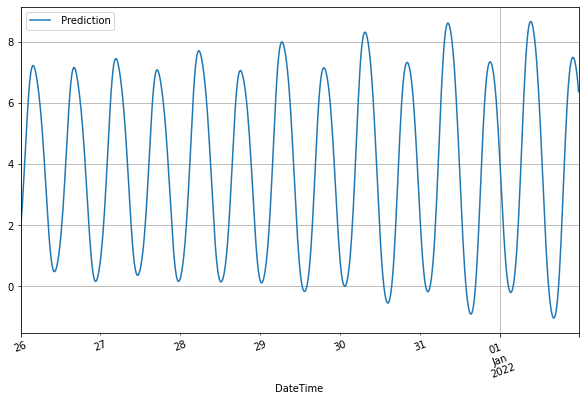

In [24]:
#@ title REST Parameters
startD = date(2021, 12, 26)  # GMT time so that
endD = date(2022, 1, 1)

startDate = startD.strftime("%Y%m%d")
endDate = endD.strftime("%Y%m%d")
stations = {'NewRochelleNY':  "8518490",
            'RyePlaylandNY':  "8518091",
            'CosCobCT':       "8469549",
            'ThrogsNeckBrNY': "8518526",
            'KingsPointNY':   "8516945",
            'BatteryNY':      "8518750",
            'BridgeportCT':   "8467150",
            'NewHavenCT':     "8465705",
            "NewboldPA":      "8548989",
            'TurkeyPointNY':  "8518962",
            }

station = stations['RyePlaylandNY']
units = "english" # "metric"
# interval = "hilo"  # hi and lo tides
# interval = "h"     # hourly 
interval = "15"      # 30,15,6,1 min
datum = "MLLW" # "STND" "MHHW" "MHW" "MTL" "MLW" "MLLW" "NAVD"
timezone = "LST_LDT" # "LST" or "GMT"
clock = "24hour" # "12hour"

noaaSite = f"https://tidesandcurrents.noaa.gov/api/datagetter?product=predictions&application=NOS.COOPS.TAC.WL&begin_date={startDate}&end_date={endDate}&datum={datum}&station={station}&time_zone={timezone}&clock={clock}&units={units}&interval={interval}&format=csv"

tideDF = pd.read_csv(noaaSite)
try:
  # convert string dates to proper date times
  tideDF['DateTime'] = tideDF['Date Time'].apply(lambda x:datetime.strptime(x, "%Y-%m-%d %H:%M"))
  minTime = tideDF['DateTime'].min()
  tideDF['hours'] = tideDF['DateTime'].apply(lambda x:(x-minTime).total_seconds()/3600)
  tideDF.plot('DateTime', ' Prediction', figsize=(10, 6), rot=20, grid=True)
except:
  print(tideDF)


In [25]:
#@title Make graphical simulation of NOAA chart
def makeTideGraph(detailDF, extremaDF):
    """
    Make tide ala NOAA from two sets of pandas DataFrames:
    detailDF -- Detailed predicted water levels for complete graph
    extremeDF -- The extrema (highs and lows)
    """
    global gTideUnit # unit switch flag

    graphFile = "resources/TideGraph.png"

    import matplotlib.transforms
    import matplotlib.dates as mdates

    today = datetime.now(tz=EST).date()

    # Set up the plot and plot the data
    # px = 1/plt.rcParams['figure.dpi']  # pixel in inches (doesn't work if bbox is 'tight')
    fig, ax = plt.subplots(figsize=(12, 4))

    ax.plot(detailDF['DateTime'], detailDF[gTideUnit], color="blue", alpha=0.8)

    # Markers at extrema with square marks
    ax.scatter(extremaDF['DateTime'], extremaDF[gTideUnit], color="blue", marker="s")
    for index, row in extremaDF.iterrows():
        xy = (row['DateTime'], row[gTideUnit])
        u = gTideUnit.split("[")[1].split("]")[0]   # row['Units']
        ax.annotate(f'{xy[1]:5.2f} {u[:2]}', xy=xy, xytext=(8,0), textcoords='offset points', color='blue')

    # Set the axis labels
    # ax.set_xlabel("Date and Time", fontsize=14, fontstyle='italic', color='SlateGray')
    ax.set_ylabel(f"Tide Level in {u}", fontsize=14, fontstyle='italic', color='SlateGray')
    # ~put an alternate axis in meters~ Alternate between meters and feet in 5min intervals

    # Put a vetical bar that marks right now.
    now = datetime.now(tz=EST)
    (ymin, ymax) = ax.get_ylim()
    ax.annotate(f"Current Time   {now.time().strftime('%I:%M %p')}", xy=(now, (ymin+ymax)/2), xytext=(-15,-30), textcoords='offset points', color='green', rotation=90.0, alpha=0.6 )
    ax.vlines(now, ymin=ymin, ymax=ymax, transform=ax.get_xaxis_transform(), colors="green", linewidth=4, alpha=0.7)

    #Fix the time axis
    ax.xaxis.set_major_locator(mdates.DayLocator(tz=EST))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EST))

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d', tz=EST))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EST))

    dx = 0.; dy = -10/72.
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    # Create offset transform by 5 points in x direction
    for label in ax.xaxis.get_majorticklabels():
        label.set(horizontalalignment='center', color="darkred", fontweight='bold')
        label.set_transform(label.get_transform() + offset)

    for label in ax.xaxis.get_minorticklabels():
        label.set(horizontalalignment='center', color="darkred")

    ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
    ax.grid(True, which='minor', linestyle="--", axis='both', alpha = 0.5)

    fig.show()
    #fig.savefig(graphFile, bbox_inches='tight', transparent=True)
    plt.close(fig)


### Run the Graph

### Cross correlations

In [ ]:
startD = date(2021, 12, 25)
endD = date(2021, 12, 30)

ryeDF = fetchTideData(stations['RyePlaylandNY'], startD, endD) 
otherDF = fetchTideData(stations['TurkeyPointNY'], startD, endD)

plt.plot(ryeDF['Hours'],ryeDF['Prediction'], color="blue", alpha=0.8)
plt.plot(otherDF['Hours'], otherDF['Prediction'], color="red", alpha=0.8)
plt.show()

You would expect to see some phase shift of tides as you move to the east or west.  (Or up an estuary)

### Harmonic Constants for a given station

With a station number we can get the parameters that predict the tide for a given location given the following parameters from NOAA.

 - Constituent #
 > Order in which the National Ocean Service lists the constituents
 - Name
 > Common name used to refer to a particular constituent, subscript refers to the number of cycles per day
 - Amplitude $A_i$
One-half the range of a tidal constituent. (*In other words the standard definition of amplitude*)
 - Phase $\Phi_i$ (*the phase of this component relative to the others*)
 > The phase lag of the observed tidal constituent relative to the theoretical equilibrium tide. = $\frac{180}{\pi}\phi$
 - Speed $\Omega_i$ (*the angular speed, a.k.a. angular frequency associated with this component*)
 > The rate change in the phase of a constituent, expressed in degrees per hour. The speed is equal to 360 degrees divided by the constituent period expressed in hours. = $\frac{180}{\pi}\;3600\;\omega$ where $\omega$ is in $rad/s$
 - Description
 > The full name of the tidal constituent

Amplitudes are in feet. Phases are in degrees, referenced to Local. Z0 (MSL): 0 feet.

The basic model would be cast as...
$$\sum_{i=1}^{32} A_i \cos(\phi_i + \omega_i t)$$

or

```python
phi   = np.pi/180. * Phase
omega = np.pi/180 * Speed / 3600.
amp   = Amplitude
```

The piece that is missing here is exactly from when do we measure the highest tide to start the calculation. From reading various reports and documents I gather that this time shift factor is reset every few years to make sure the calculation matches up with the measurements (NOAA is always checking against actual readings.)



In [ ]:
#@title Harmonic Constants for Rye Playland Beach
site = "https://tidesandcurrents.noaa.gov/harcon.html?id=" + stations['RyePlaylandNY']

constDF = pd.read_html(site, header=0)[0]
constDF['phi'] = constDF['Phase'] * np.pi / 180.0
constDF['omega'] = constDF['Speed'] * np.pi / 180.0 / 3600.0

coefs = constDF[['Amplitude','phi','omega']].to_numpy()

In [ ]:
#@markdown `tide` calculates the amplitude based on the parameters
def tide(terms, time):
  tideLevel = 0.0
  for [amp,phi,omega] in terms:
    tideLevel += amp * np.cos(omega * time + phi)
    # for point of reference this takes about 50 lines of Fortran Code
  return tideLevel

# initialize the arrays
hours = np.array([])
hgt = np.array([])

# this ought to be 'vectorizable' but I can't seem to get it to work.
for h in range(3*24): # a week
  hours = np.append(hours, h)
  hgt = np.append(hgt, tide(coefs, h*3600))

plt.plot(hours,hgt)

plt.show()

Superimpose the harmonic estimation with the data passed from a REST call to the NOAA site.

In [ ]:
startD = datetime(2021, 12, 20, 2, 0, tzinfo=EDT)
endD = datetime(2021, 12, 30, 2, 0, tzinfo=EDT)

tideDF = fetchTideData(stations['RyePlaylandNY'], startD, endD) 

d1 = tideDF['DateTime'].min() #datetime(2021, 12, 28, 0, 0, 0, tzinfo=EDT)
d2 = tideDF['DateTime'].max() #datetime(2021, 12, 30, 8, 0, 0, tzinfo=EDT)

hgt = np.array([])

intrv = np.linspace(d1.toordinal()*24, 24+d2.toordinal()*24, num=300, endpoint=True)
shift = 12.2  # time phase shift
for i in intrv:
  hgt = np.append(hgt, tide(coefs, (i-shift)*3600))


plt.figure(figsize=(20,6))
# Plot the harmonic values
plt.plot((intrv-intrv.min()), hgt+3.5)
plt.xticks([i for i in range(0,260,12)])


restHours = tideDF['Hours'].to_numpy()
restAmp = tideDF['Prediction'].to_numpy()

plt.scatter(restHours, restAmp, alpha=0.6)
plt.grid(True)
plt.show()


## Tide Clock Design Notes

So how to make an easily seen display of the tide situation. I have in my hardware kits:
  - Nested NeoPixel Wheels, a stack of 1+8+12+16+24+32 or 61 pixels in total
  - individual neopixels galore
  - Mechanical indicators are not out of the question.
  - How about a discarded 720p display in a case run by a Raspberry Pi?



### Round 1

Use an old Dell Screen which was to be decommisioned.
  - Program a **Raspberry Pi B v1.1** to drive the screen
      - Design and layout the graphics
      - Power the ℿ from the 12V audio connection (*Buck converter*)
  - Build a 'weather resistant' case from wood and plexi.
  - Design a mount for placing where the clock was.

Need to consider things to put on the screen (plenty-o real estate)
  - The graph of the next 48 hours (format the way NOAA does it)
  - The time of the next tide extrema (high or low)
  - Moon phase?
  - subtle clues as to when the last access of NOAA data was.
  - Grab data from NOAA in a responsible way (once every 24 hours?)
  - Today's Date (of course)
  - Weather data?

References:
 - [Rye Playland, Harmonic Calculations](https://tidesandcurrents.noaa.gov/noaatidepredictions.html?id=8518091)  Harmonic estimates checked against measurements.
 - [Larchmont Harbor, NY](https://marine.weather.gov/MapClick.php?lat=40.9251&lon=-73.7391#.YdDNYWjMIkk)  Gives the marine version of the weather.


We need to understand how dates work in python.

After some side explorations I now understand date, time and datetime and the proper way to shift time values.  Short caption: always try to work with 'aware' time values.

For example: date.today() returns the date at UTC, which means if I want the date for here (UTC-4,5) the date will be wrong.  Solution: start with 'aware' datetimes

These are global values used with subsequent cells

In [3]:
# With each call we flip the units so we toggle back and 
#      forth between metric and imperial (we have an international audience)
idx = 0
measure = ("english", "metric")
stations = {'NewRochelleNY':  "8518490",
            'RyePlaylandNY':  "8518091",
            'CosCobCT':       "8469549",
            'ThrogsNeckBrNY': "8518526",
            'KingsPointNY':   "8516945",
            'BatteryNY':      "8518750",
            'BridgeportCT':   "8467150",
            'NewHavenCT':     "8465705",
            "NewboldPA":      "8548989",
            'TurkeyPointNY':  "8518962",
            }

tideStation = stations['RyePlaylandNY']

We don't want to be hammering on the NOAA servers every 5 minutes so lets download the tide data once per day and save it.  This cell developes the way to do this.

In [4]:
#@title fetchDailyTides
def fetchDailyTides(fromTideStation):
    """
    """
    detailTidesFile = 'DetailTides.zip'  # 15 minute intervals (for smooth graph)
    extremTidesFile = 'ExtremTides.zip'  # Just the hi and low values for extrema

    # Fetch this data once per day.  And run all the subsequent graphics from this.
    now       = datetime.now(tz=EDT)
    today     = now.date()

    # Proper way to set up timeshifts.
    yesterday = now - timedelta(days=0)
    tomorrow  = now + timedelta(days=2)
    # print(f"today: {today} yesterday:{yesterday} tom:{tomorrow}")

    # look for existing data, if not found: create, if found: load and test for age
    try:
        # print("Try to read saved data...")
        tideDetailDF = pd.read_pickle(detailTidesFile, compression='infer')
        tideExtremDF = pd.read_pickle(extremTidesFile, compression='infer')
    except FileNotFoundError:
        # print("File doesn't exist, creating...")
        # Get the data
        tideDetailDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date())
        tideDetailDF.to_pickle(detailTidesFile, compression='infer')
        tideExtremDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date(), interval='hilo')
        tideExtremDF.to_pickle(extremTidesFile, compression='infer')

    # test detail data frame for age...
    if tideDetailDF['DateTime'][1].date()!=today:
        tideDetailDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date())
        tideDetailDF.to_pickle(detailTidesFile, compression='infer')

    # test extrema data frame for age...
    if tideExtremDF['DateTime'][1].date()!=today:
        tideExtremDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date(), interval='hilo')
        tideExtremDF.to_pickle(extremTidesFile, compression='infer')

    # print(f"15min file: {tideDetailDF['DateTime'][1].date()} curr:{today}")
    # print(f"Extrm file: {tideExtremDF['DateTime'][0].date()} curr:{today}")
    return (tideDetailDF, tideExtremDF)


In [5]:
(ryeDF, ryeDFExt) = fetchDailyTides(tideStation)
ryeDFExt.head()

Try to read saved data...


,Date Time,Tide [ft],Type,DateTime,Hours,Date,Time,Tide [m],Units
0,2022-01-05 00:43,7.443,H,2022-01-05 00:39:00-05:00,0.000000,2022-01-05,00:43,2.268626,ft Feet
1,2022-01-05 07:01,-0.470,L,2022-01-05 06:57:00-05:00,6.300000,2022-01-05,07:01,-0.143256,ft Feet
2,2022-01-05 12:59,8.035,H,2022-01-05 12:55:00-05:00,12.266667,2022-01-05,12:59,2.449068,ft Feet
3,2022-01-05 19:43,-0.857,L,2022-01-05 19:39:00-05:00,19.000000,2022-01-05,19:43,-0.261214,ft Feet
4,2022-01-06 01:37,7.298,H,2022-01-06 01:33:00-05:00,24.900000,2022-01-06,01:37,2.224430,ft Feet


Pull the data from the store and generate a plot that resembles the NOAA tide graph.  I chose this because I like the way it presents the tide data.

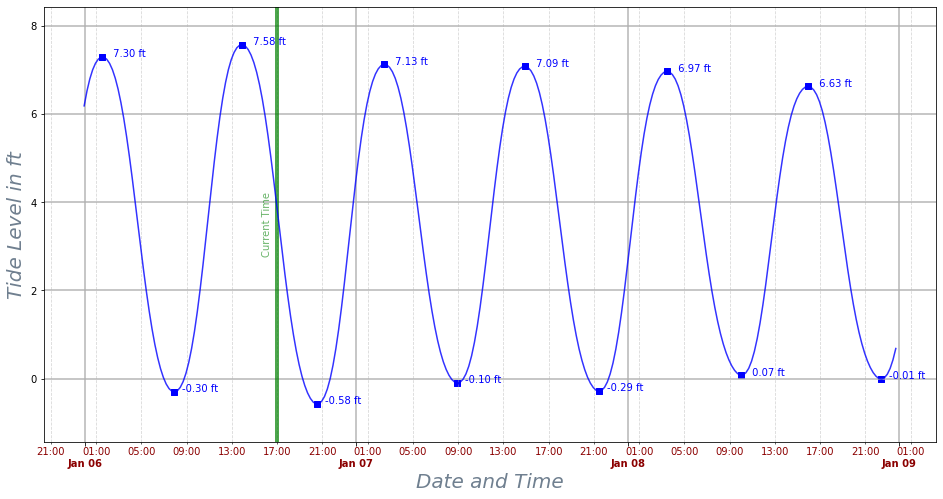

In [7]:
#@title Graphical simulation of NOAA chart
def makeTideGraph(detailDF, extremaDF):
    """
    makeTideGraph
    """
    global idx # unit switch flag
    idx = (idx + 1)%2

    graphFile = "TideGraph.png"

    import matplotlib.transforms
    import matplotlib.dates as mdates

    today = datetime.now(tz=EDT).date()

    # Set up the plot and plot the data
    fig, ax = plt.subplots(figsize=(16, 8))

    # pick the units based on idx
    predCol = ('Tide [m]','Tide [ft]')[idx]

    # %%
    ax.plot(detailDF['DateTime'], detailDF[predCol], color="blue", alpha=0.8)

    # Markers at extrema with square marks
    ax.scatter(extremaDF['DateTime'], extremaDF[predCol], color="blue", marker="s")
    for index, row in extremaDF.iterrows():
        xy = (row['DateTime'], row[predCol])
        u = predCol.split("[")[1].split("]")[0]   # row['Units']
        ax.annotate(f'{xy[1]:5.2f} {u[:2]}', xy=xy, xytext=(8,0), textcoords='offset points', color='blue')

    # Set the axis labels
    ax.set_xlabel("Date and Time", fontsize=20, fontstyle='italic', color='SlateGray')
    ax.set_ylabel(f"Tide Level in {u}", fontsize=20, fontstyle='italic', color='SlateGray')
    # ~put an alternate axis in meters~ Alternate between meters and feet in 5min intervals

    # Put a vetical bar that marks right now.
    now = datetime.now(tz=EDT)
    (ymin, ymax) = ax.get_ylim()
    ax.annotate("Current Time", xy=(now, (ymin+ymax)/2), xytext=(-15,-30), textcoords='offset points', color='green', rotation=90.0, alpha=0.6 )
    ax.vlines(now, ymin=ymin, ymax=ymax, transform=ax.get_xaxis_transform(), colors="green", linewidth=4, alpha=0.7)

    #Fix the time axis
    ax.xaxis.set_major_locator(mdates.DayLocator(tz=EDT))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EDT))

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d', tz=EDT))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EDT))

    dx = 0.; dy = -10/72.
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    # Create offset transform by 5 points in x direction
    for label in ax.xaxis.get_majorticklabels():
        label.set(horizontalalignment='center', color="darkred", fontweight='bold')
        label.set_transform(label.get_transform() + offset)

    for label in ax.xaxis.get_minorticklabels():
        label.set(horizontalalignment='center', color="darkred")

    ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
    ax.grid(True, which='minor', linestyle="--", axis='both', alpha = 0.5)

    # fig.show()
    fig.savefig(graphFile, bbox_inches='tight')

# Get the data this method tries to fetch from local store first
(ryePlayDetailDF, ryePlayExtremDF) = fetchDailyTides(tideStation)

makeTideGraph(ryePlayDetailDF, ryePlayExtremDF)


The above graphic is pretty close to what NOAA produces.  It shows the future (and a little of the past) of where the tides will be graphically.  The next step is to summarize the next few extrema in a simple graphic.

In [8]:
#@title Develop the short table for todays extrema

# from IPython.core.display import display_html
# We assume that the above graphic was run already so we can 
# count on ryeDFExt existing

# This won't be necessary when we write it to a file.
# from IPython.display import display, HTML
def makeTideTable(extremaDF):
    global idx
    predCol = ('Tide [m]','Tide [ft]')[idx]
    lbl = {'H': 'HIGH', 'L': 'LOW'}

    now = datetime.now(tz=EDT)

    templateFile = "TideClockTmpl.html"
    tideFile = "TideClock.html"
        # pick the units based on idx

    sel = extremaDF['DateTime'] > now
    futureTides = extremaDF[sel]

    htmlText = futureTides[:4].to_html( 
                            columns=['Date', 'Time', 'Type', predCol], 
                            index=False, 
                            border=0,
                            formatters={
                                predCol: lambda x:f"{x:6.3}",
                                'Type': lambda l: lbl[l]
                                },
                            table_id = "tideTable"
                            )

    #open the template file
    templateFile = open("TideClockTmpl.html", "r")
    templateData = templateFile.readlines()
    templateFile.close()

    # copy the html table into the text and write out a new file 
    tideFile = open("TideClock.html", "w")
    tideFile.write( ("".join(templateData)).replace('<!--Table Place-->', htmlText) )
    tideFile.close()


makeTideTable(ryePlayExtremDF)

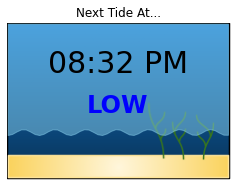

In [9]:
#@title Generate the 'next tide' graphic.

#@markdown Fetch custom background image
def makeTideGraphic(extremaDF):
    global idx
    predCol = ('Tide [m]','Tide [ft]')[idx]
    lbl = {'H': 'HIGH', 'L': 'LOW'}

    now = datetime.now(tz=EDT)

    imageOverLay = "https://docs.google.com/drawings/d/e/2PACX-1vRPpyCKk834LQUUwoEWDiopLKIcRscn3AoUPynXzNe6jPRLXWt9TBS90Wwm_MjxVoqezD09hbx_0Sw8/pub?w=225&h=159"

    im = plt.imread(imageOverLay)
    plt.figure(figsize=(4,4))

    implot = plt.imshow(im)
    implot.axes.get_xaxis().set_visible(False)
    implot.axes.get_yaxis().set_visible(False)

    hgt = 125 #159
    wdt = 222 #225
    lvl = 110

    upcoming = extremaDF[extremaDF['DateTime']>datetime.now(tz=EDT)]
    nxtTide = upcoming.iloc[0]
    plt.text(wdt/2, 50, nxtTide['DateTime'].strftime("%I:%M %p"), fontsize=30.0, ha='center' )
    plt.text(wdt/2, 90, lbl[nxtTide['Type']], fontweight='heavy', color='blue', fontsize=24.0, ha='center')

    # Somehwat kludgy since we know the range is between -1 and 10
    if predCol == 'Tide [ft]':
        scaledTideHeight = hgt - lvl*(nxtTide[predCol] + 2)/10.
    else:
        scaledTideHeight = hgt - lvl*(nxtTide[predCol] + 0.5)/3.0

    plt.title("Next Tide At...")
    plt.axis('off')
    t=np.linspace(0,wdt,50)
    y=scaledTideHeight + np.cos(t/5) * 3
    plt.fill_between(t,y, color="SkyBlue", alpha=0.50)

    #plt.show()
    plt.savefig("TideNext.png", bbox_inches='tight')

makeTideGraphic(ryePlayExtremDF)

### Other Ideas

#### Weather

Developed the principal graphics and tables, now pull in weather information from [marine NOAA site](https://marine.weather.gov/MapClick.php?lat=40.9251&lon=-73.7391#.YdIjbWjMIkm)



In [ ]:
weatherSite = "https://marine.weather.gov/MapClick.php?lat=40.9251&lon=-73.7391#.YdIjbWjMIkm"
weatherDF = pd.read_html(weatherSite)

[Weather API](https://www.weather.gov/documentation/services-web-api)
May be able to provide some direct help.

Use this to get the map grid to get the location
    https://api.weather.gov/points/{latitude},{longitude}

```
    "properties": {
        "@id": "https://api.weather.gov/points/40.9251,-73.7390999",
        "@type": "wx:Point",
        "cwa": "OKX",
        "forecastOffice": "https://api.weather.gov/offices/OKX",
        "gridId": "OKX",
        "gridX": 40,
        "gridY": 45,
        "forecast": "https://api.weather.gov/gridpoints/OKX/40,45/forecast",
        "forecastHourly": "https://api.weather.gov/gridpoints/OKX/40,45/forecast/hourly",
        "forecastGridData": "https://api.weather.gov/gridpoints/OKX/40,45",
        "observationStations": "https://api.weather.gov/gridpoints/OKX/40,45/stations",
        "relativeLocation": {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [
                    -73.751959999999997,
                    40.925961000000001
                ]
            },
            "properties": {
                "city": "Larchmont",
                "state": "NY",
                "distance": {
                    "unitCode": "wmoUnit:m",
                    "value": 1084.6714461509
                },
                "bearing": {
                    "unitCode": "wmoUnit:degree_(angle)",
                    "value": 95
                }
            }
        },
```

In [2]:
# !curl "https://api.weather.gov/points/40.9251,-73.7391" 
!curl "https://api.weather.gov/gridpoints/OKX/40,45/forecast"

{
    "correlationId": "374a5d1e",
    "title": "Unexpected Problem",
    "type": "https://api.weather.gov/problems/UnexpectedProblem",
    "status": 500,
    "detail": "An unexpected problem has occurred.",
    "instance": "https://api.weather.gov/requests/374a5d1e"
}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   269  100   269    0     0    269      0  0:00:01 --:--:--  0:00:01   747


#### Moon Phase

Moon phase with slight background
The URL is a complicated but accurate description of phase e.g.  moon_day_[] where brackets are replaced with...
 - WaxC_## | WaxG_##  (*C*rescent, *G*ibbous)
    - where ## in % in increments
 - first, last, full, new

![waxing 35%](https://www.moongiant.com/images/today_phase/moon_day_WaxG_95.jpg)

Large moon phase based on % provided in URL
![Moon phase based on %#](https://nineplanets.org/static/lib/astro/images/shadow-80.png)

#### Direct observation of tides

In [ ]:
%%html
#<iframe src="https://www.wpc.ncep.noaa.gov/basicwx/bwxloop_ndfd.html" width="1100px" height="820px"></iframe>

[Mamaroneck Web Cam](https://www.weatherbug.com/weather-camera/?cam=MMBPC) for checking the tides?

# Experimentation

This is an experimental area for exploring how to implement permanence across executions.
Environmental variables are things that are read but not saved in the shell environment. So we need a better way to save the state of our envgine.  python has a native library called [configparser](https://docs.python.org/3/library/configparser.html) which handles much of the overhead internally.

In [ ]:
import configparser
buildconfig = configparser.ConfigParser()

# quick setup and definition
buildconfig['DEFAULT'] = {'TideUnits': 'Tide [ft]',
                     'Yesterday': 0,
                     'Tomorrow': 2,
                     # Rye Playland, NY (Harmonic Station)
                     'Station': 8518091
                     }

# funny, we can read 
with open('.env', 'w') as envFile:
    buildconfig.write(envFile)


In [ ]:
#
config = configparser.ConfigParser()
config.read('.env')
defaults = config['DEFAULT']

print([f"{k}: {v}" for (k,v) in defaults.items()])

tideUnits = defaults.get('tideunits','Tide [ft]')
yesterdayDelta = defaults.getint('yesterday', fallback=-1)
tomorrowDelta = defaults.getint('tomorrow', fallback=3)
station = defaults.get('station')
print(f"'{tideUnits}' '{station}' {yesterdayDelta}-{tomorrowDelta}")



In [ ]:
defaults['tideunits']  = 'Tide [cubit]'

# only way to save, as mentioned above, it can read with a string to the file but
# requires this additional overhead to save.
with open('.env', 'w') as envFile:
    config.write(envFile)

In [ ]:
gv = 1

def incr2():
    global gv, ev, ov
    gv += 2

def incr1():
    # doesn't work
    gv = 22

def oper():
    print(gv)
    incr1()
    print(gv)
    incr2()
    print(gv)

oper()

In [ ]:
#import config

config.a = 1
config.b = 'two'

In [ ]:
graphFile = 'graphic.png'
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from pytz import timezone  # should already be part of pandas but it doesn't hurt to do it again.
EST = timezone('America/New_York')

# Getting Weather Data
import html5lib
import pandas as pd

now = datetime.now(tz=EST)

windDF = pd.read_html("https://www.ndbc.noaa.gov/station_page.php?station=44022", match='Previous observations', header=1)[0]
windDF['Time'] = windDF['TIME(EST)'].apply(lambda t: datetime.strptime(t, "%I:%M %p").replace(tzinfo=EST).time())
windDF['Date'] = windDF[['MM','DD']].apply(lambda md: date(year=now.year, month=md[0], day=md[1]), axis=1)   #print(f"{md[0]}-{md[1]}")
windDF['DateTime'] = windDF[['Date','Time']].apply(lambda dt: datetime.combine(dt[0], dt[1], tzinfo=EST), axis=1)



windDF.plot('DateTime', 'WSPDkts')
plt.grid(True)
plt.ylabel("Wind Speed [knts]")


In [ ]:
import matplotlib.transforms
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(windDF['DateTime'], windDF['WSPDkts'], 'bo', alpha=0.8)

# Set the axis labels
ax.set_xlabel("Date and Time", fontsize=10, fontstyle='italic', color='SlateGray')
ax.set_ylabel("Wind Speed [knts]", fontsize=10, fontstyle='italic', color='SlateGray')

#Fix the time axis
ax.xaxis.set_major_locator(mdates.DayLocator(tz=EST))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EST))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d', tz=EST))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EST))

dx = 0.; dy = -10/72.
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# Create offset transform by 5 points in x direction
for label in ax.xaxis.get_majorticklabels():
    label.set(horizontalalignment='center', color="darkred", fontweight='bold')
    label.set_transform(label.get_transform() + offset)

for label in ax.xaxis.get_minorticklabels():
    label.set(horizontalalignment='center', color="darkred")

ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
ax.grid(True, which='minor', linestyle="--", axis='both', alpha = 0.5)
ax.set_ylim(bottom=0.0)

#fig.show()
fig.savefig(graphFile, bbox_inches='tight')
plt.close(fig)

# Wind Data
There are actual data stations within a few klicks of our YC so why not use some of our real estate to display the information?

In [2]:
#@title test of gathering wind data.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta
from pytz import timezone  # should already be part of pandas but it doesn't hurt to do it again.

EST = timezone('America/New_York')
UTC = timezone('UTC')

import matplotlib.transforms
import matplotlib.dates as mdates

# Getting Weather Data from execution rocks (station 44022)  Only needs to run every 15 minutes.

In [3]:
# Exscution Rocks weather buoy
realEXR_TimeDataFile = "https://www.ndbc.noaa.gov/data/realtime2/44022.txt"
# Kings Point
realKPS_TimeDataFile = "https://www.ndbc.noaa.gov/data/realtime2/KPTN6.txt"
# Western Long Island Sound
realWLI_TimeDataFile = "https://www.ndbc.noaa.gov/data/realtime2/44040.txt"

### Fetch Wind Data

In [108]:
def fetchWindData(dataSetSite):
  now = datetime.now(tz=EST)
  def filtMM(x):
    x[x != 'MM'].apply(float)
#    x[x == 'MM'] = 5000.

  windDF = pd.read_csv(dataSetSite, delim_whitespace=True, header=[0,1], nrows=450, na_values='MM' )
  print(f"\t...got {len(windDF)} data values")

  windDF['DateTime'] = windDF[['#YY','MM','DD','hh','mm']].apply(lambda dt: datetime(dt[0], dt[1], dt[2], dt[3], dt[4], tzinfo=UTC).astimezone(EST), axis=1)
  windDF['Time'] = windDF['DateTime'].apply(lambda t: t.time())
  windDF['Date'] = windDF['DateTime'].apply(lambda d: d.date())
  # windDF['WDIR'] = windDF['WDIR'].apply(filtMM)
  # windDF['GST'] = windDF['GST'].apply(filtMM)

  return windDF #.set_index(windDF['DateTime'] - windDF['DateTime'].min()) # returns a new copy
#  return windDF.set_index('DateTime')


In [109]:
df = fetchWindData(realEXR_TimeDataFile)
df.head()

	...got 450 data values


,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,...,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE,DateTime,Time,Date
,#yr,mo,dy,hr,mn,degT,m/s,m/s,m,sec,...,hPa,degC,degC,degC,nmi,hPa,ft,,,
0,2022,1,20,19,45,320.0,6.0,7.0,NaN,NaN,...,NaN,1.3,NaN,-3.8,NaN,NaN,NaN,2022-01-20 14:45:00-05:00,14:45:00,2022-01-20
1,2022,1,20,19,0,330.0,6.0,NaN,NaN,NaN,...,NaN,1.2,NaN,-3.2,NaN,NaN,NaN,2022-01-20 14:00:00-05:00,14:00:00,2022-01-20
2,2022,1,20,18,45,330.0,5.0,7.0,NaN,NaN,...,NaN,1.1,NaN,-2.5,NaN,NaN,NaN,2022-01-20 13:45:00-05:00,13:45:00,2022-01-20
3,2022,1,20,18,15,360.0,5.0,6.0,NaN,NaN,...,NaN,1.0,NaN,-1.9,NaN,NaN,NaN,2022-01-20 13:15:00-05:00,13:15:00,2022-01-20
4,2022,1,20,17,45,360.0,5.0,6.0,NaN,NaN,...,NaN,0.6,NaN,-1.5,NaN,NaN,NaN,2022-01-20 12:45:00-05:00,12:45:00,2022-01-20


In [ ]:
# df['GST']=df['GST'].replace({'MM':0})
# df['PRES']=df['PRES'].replace({'MM':800})
sel = df['GST']!='MM'
dfm = df[sel['m/s']]
ndfm = dfm.apply(lambda x: print(x), axis=1, raw=True)
# dfm.applymap(lambda x: float(x))
# n = len(dfm['GST'])

# for i in ndfm['GST']['m/s'].keys():
#     if type(ndfm['GST']['m/s'][i]) is str:
#         print(f"{i}: '{ndfm['GST']['m/s'][i]}'")
#     else:
#         print(f"{i}: {10.0*ndfm['GST']['m/s'][i]}")


In [110]:
now = datetime.now().astimezone(EST)
d = timedelta(days = 2)
sel = df['DateTime'] > (now - d)
ndf = df[sel].resample('2H', on='DateTime').mean()
ndf.head()

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
,#yr,mo,dy,hr,mn,degT,m/s,m/s,m,sec,sec,degT,hPa,degC,degC,degC,nmi,hPa,ft
DateTime,,,,,,,,,,,,,,,,,,,
2022-01-18 14:00:00-05:00,2022.0,1.0,18.0,20.0,45.0,300.0,9.00,12.00,NaN,NaN,NaN,NaN,NaN,2.000,NaN,-7.100,NaN,NaN,NaN
2022-01-18 16:00:00-05:00,2022.0,1.0,18.0,21.5,30.0,300.0,8.00,8.75,NaN,NaN,NaN,NaN,NaN,1.425,NaN,-7.125,NaN,NaN,NaN
2022-01-18 18:00:00-05:00,2022.0,1.0,18.5,11.5,30.0,302.5,6.25,7.00,NaN,NaN,NaN,NaN,NaN,0.425,NaN,-7.300,NaN,NaN,NaN
2022-01-18 20:00:00-05:00,2022.0,1.0,19.0,1.5,30.0,290.0,4.50,6.25,NaN,NaN,NaN,NaN,NaN,-0.250,NaN,-7.525,NaN,NaN,NaN
2022-01-18 22:00:00-05:00,2022.0,1.0,19.0,3.5,30.0,285.0,3.75,6.25,NaN,NaN,NaN,NaN,NaN,-0.800,NaN,-7.225,NaN,NaN,NaN


In [47]:
ndf.shape

(15, 9)

### Graph the wind data

In [54]:
def makeWindGraph(windDF):
  graphFile = "resources/WindGraph.png"
  fig, ax = plt.subplots(figsize=(8, 4))

  tme = windDF.index
  wspd = windDF['WSPD'] # windDF['WSPD']
  mxsp = windDF['GST'] # windDF['GST']

  ax.plot(tme, wspd/0.447, 'bo-', alpha=0.8)
  ax.plot(tme, mxsp/0.447, 'ro-', alpha=0.8)

  ax.set_ylim(bottom=4.0)

  yloc = 3 * wspd  / wspd
  angl = windDF['WDIR']
  ax.quiver(tme, yloc, np.cos(np.pi*angl/np.pi), np.sin(np.pi*angl/np.pi), angles='uv', color='orange', alpha=0.6, pivot='middle')

  # Set the axis labels
  # ax.set_xlabel("Date and Time", fontsize=10, fontstyle='italic', color='SlateGray')
  ax.set_ylabel("Wind Speed [mph]", fontsize=12, fontstyle='italic', color='SlateGray')

  #Fix the time axis
  ax.xaxis.set_major_locator(mdates.DayLocator(tz=EST))
  ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EST))

  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d', tz=EST))
  ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EST))

  dx = 0.; dy = -10/72.
  offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
  # Create offset transform by 5 points in x direction
  for label in ax.xaxis.get_majorticklabels():
      label.set(horizontalalignment='center', color="darkred", fontweight='bold')
      label.set_transform(label.get_transform() + offset)

  for label in ax.xaxis.get_minorticklabels():
      label.set(horizontalalignment='center', color="darkred")

  ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
  ax.grid(True, which='minor', linestyle="--", axis='both', alpha = 0.5)
  ax.set_ylim(bottom=0.0)

#  fig.show()
  fig.savefig(graphFile, bbox_inches='tight', transparent=True)
  plt.close(fig)


### Main

In [55]:
print("Build wind graph...")

now = datetime.now().astimezone(EST)
d = timedelta(days = 2)

theDF = fetchWindData(realWLI_TimeDataFile)

smpl = theDF['DateTime'] > (now - d)
makeWindGraph( theDF[smpl].resample('2H', on='DateTime').mean() )
# print(theDF.rank)


Build wind graph...
	...got 450 data values
